In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [4]:
dataset = np.load('../data/not_bright/imgs_0001.npy')
targets = np.load('../data/not_bright/masks_0001.npy')

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

## Retrain the network

In [6]:
dataset1 = np.load('../data/not_bright/imgs_0000.npy')
targets1 = np.load('../data/not_bright/masks_0000.npy')

track_targets1 = targets.copy()
track_targets1[track_targets1 <=0] = 0

In [7]:
dataset0 = dataset
track_targets0 = track_targets
targets0 = targets

dataset = np.stack((dataset0, dataset1))
targets = np.stack((targets0, targets1))
track_targets = np.stack((track_targets0, track_targets1))

In [8]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

In [10]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[1, 1, 1],
                      c_sub_obj_cs=[1e-1, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-3)

INFO (theano.gof.compilelock): Refreshing lock /home/apanin/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.6-Carbon-x86_64-2.7.11-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/apanin/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.6-Carbon-x86_64-2.7.11-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/apanin/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.6-Carbon-x86_64-2.7.11-64/lock_dir/lock


In [11]:
network.load('../weights', '3cascades_trained')

<IPython.core.display.Javascript object>


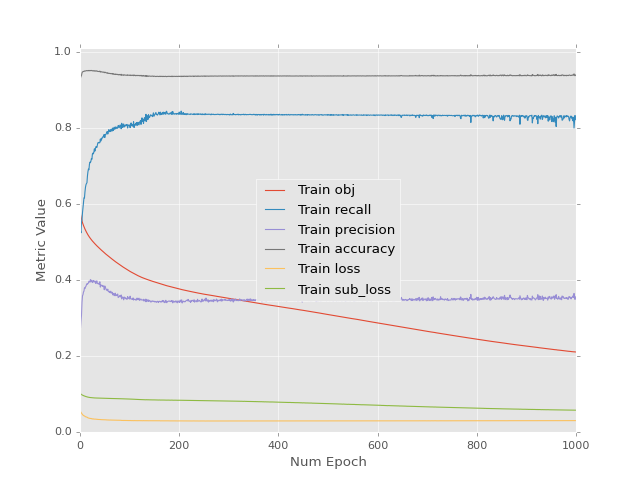

<IPython.core.display.Javascript object>


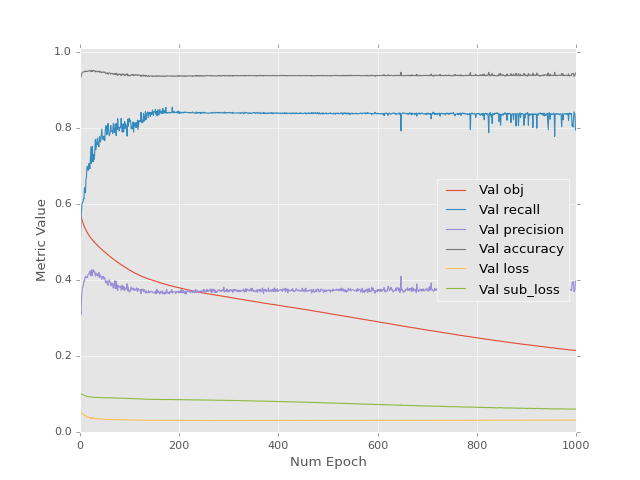

<IPython.core.display.Javascript object>


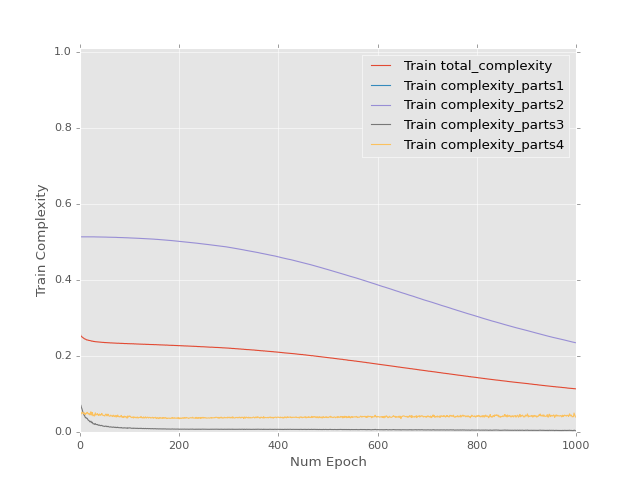

<IPython.core.display.Javascript object>


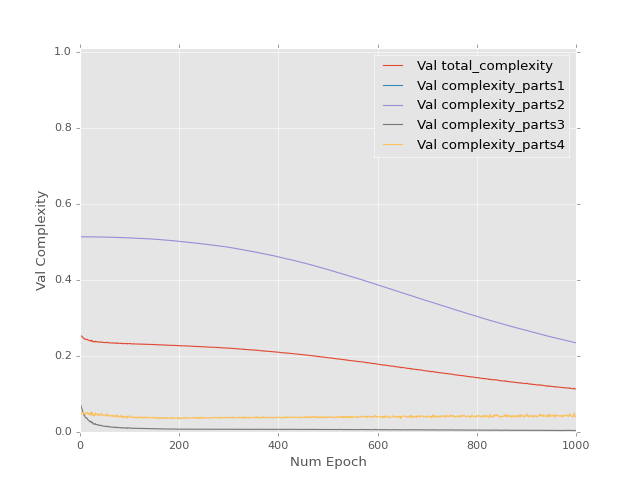

Epoch 1 of 1000 took 28.681s


/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


Epoch 2 of 1000 took 28.844s
Epoch 3 of 1000 took 30.660s
Epoch 4 of 1000 took 30.052s
Epoch 5 of 1000 took 30.410s
Epoch 6 of 1000 took 29.960s
Epoch 7 of 1000 took 30.005s
Epoch 8 of 1000 took 29.923s
Epoch 9 of 1000 took 30.109s
Epoch 10 of 1000 took 29.902s
Epoch 11 of 1000 took 29.859s
Epoch 12 of 1000 took 29.800s
Epoch 13 of 1000 took 29.788s
Epoch 14 of 1000 took 29.869s
Epoch 15 of 1000 took 29.999s
Epoch 16 of 1000 took 29.642s
Epoch 17 of 1000 took 29.734s
Epoch 18 of 1000 took 29.595s
Epoch 19 of 1000 took 29.776s
Epoch 20 of 1000 took 29.728s
Epoch 21 of 1000 took 29.728s
Epoch 22 of 1000 took 29.614s
Epoch 23 of 1000 took 29.663s
Epoch 24 of 1000 took 29.702s
Epoch 25 of 1000 took 29.760s
Epoch 26 of 1000 took 29.850s
Epoch 27 of 1000 took 29.571s
Epoch 28 of 1000 took 29.638s
Epoch 29 of 1000 took 29.688s
Epoch 30 of 1000 took 29.659s
Epoch 31 of 1000 took 29.615s
Epoch 32 of 1000 took 29.726s
Epoch 33 of 1000 took 29.774s
Epoch 34 of 1000 took 29.651s
Epoch 35 of 1000 t

In [12]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=1000,
      batch_size=50)

# Check results

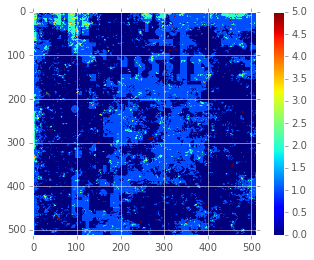

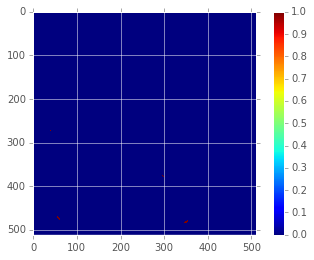

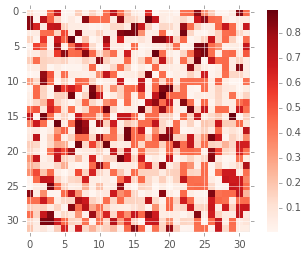

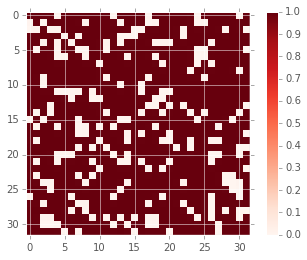

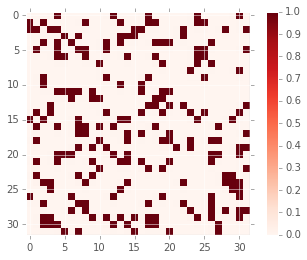

In [41]:
%matplotlib inline
i = np.random.choice(X_y[-1].shape[0])

plt.imshow(X_y[1][i][0])
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i][0], interpolation='none')
plt.colorbar()
plt.show()

prediction = network.predict(X_y[1][i-1:i].astype(np.float32))

plt.imshow(prediction[0, 0], interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

# Precision Vs Recall

In [45]:
import theano
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

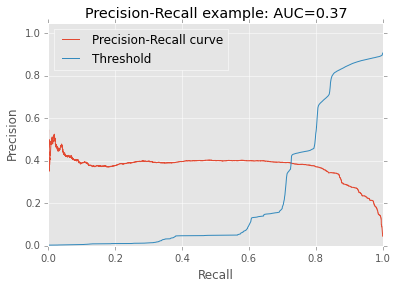

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [85]:
precision[10000]

0.10983144181048955

In [86]:
thr[10000]

0.011953057

In [87]:
recall[10000]

0.99543517954960437

# Final train

<IPython.core.display.Javascript object>


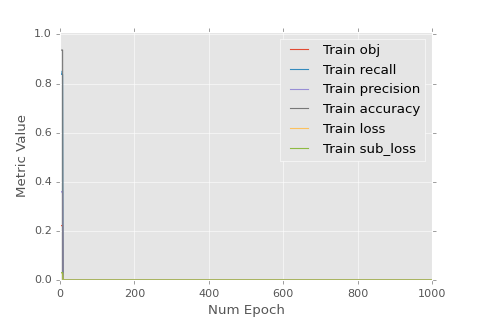

<IPython.core.display.Javascript object>


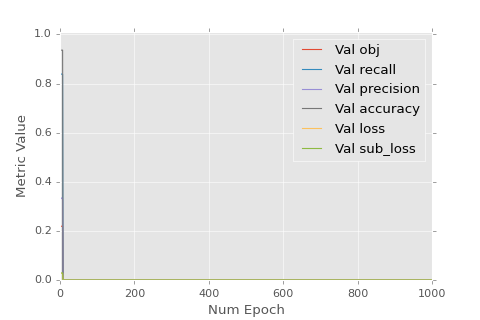

<IPython.core.display.Javascript object>


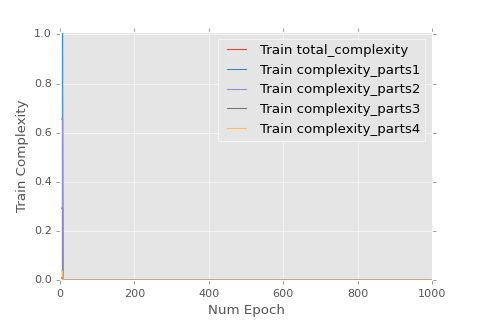

<IPython.core.display.Javascript object>


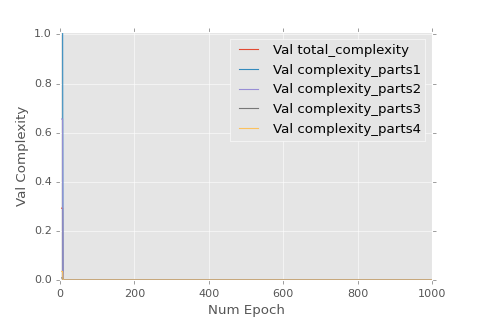

Epoch 1 of 1000 took 28.806s
Epoch 2 of 1000 took 28.808s
Epoch 3 of 1000 took 29.136s
Epoch 4 of 1000 took 29.167s
Epoch 5 of 1000 took 29.236s
Epoch 6 of 1000 took 29.338s
Epoch 7 of 1000 took 29.294s
Epoch 8 of 1000 took 29.398s


In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=1000,
      batch_size=50)

In [13]:
network.save('../weights', '3cascades_long_train')